- Goal: Calibrate PI of ar1-4(T=10)
- 沒有收錄在論文當中

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


# 自訂 function 可重新 reload
from importlib import reload
from utils import util_inference_result
reload(util_inference_result)
from utils.util_inference_result import *

from scipy.stats import norm


# Read data

In [2]:
main_folder_path = "/home/hchuang/Documents/Project/"

# I2
folder_path = main_folder_path + "SSSD_CP/src/results/ar1/ar1-4/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_I2/"
pred_data_I2 = read_multiple_imputations(folder_path, 1)
true_data_I2 = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

print(f"pred_data_I2, shape: {pred_data_I2.shape}")
print(f"true_data_I2, shape: {true_data_I2.shape}")

# test data
folder_path = main_folder_path + "SSSD_CP/src/results/ar1/ar1-4/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_test/"
pred_data_test = read_multiple_imputations(folder_path, 1)
true_data_test = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

print(f"pred_data_test, shape: {pred_data_test.shape}")
print(f"true_data_test, shape: {true_data_test.shape}")

# test data all (whole series) for calculating true conditional distribution 0.8*y_2 in Comparison section
true_data_all_test = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/AR/test_ar1_1000_10.npy')

pred_data_I2, shape: (100, 10000, 1, 1)
true_data_I2, shape: (10000, 1, 1)
pred_data_test, shape: (100, 1000, 1, 1)
true_data_test, shape: (1000, 1, 1)


# QPI

In [3]:
# prediction interval and coverage rate
L_star_model, U_star_model = pred_interval(pred_data_test, beta = 0.05)
CR_test_model = coverage_rate(L_star_model, U_star_model, true_data_test)
print(CR_test_model)

[[0.204]]


# Method 1: CPI_B

In [4]:
# Compute E*
pred_data = pred_data_I2
true_data = true_data_I2

L, U = pred_interval(pred_data, beta = 0.05)
# L, U = case_setting(L, U, case = interval_case) # modify interval

E_star = compute_E_star(L, U, true_data, alpha = 0.05)
L_star, U_star = adjust_PI(L, U, E_star)

print(f'E_star_L: {E_star}')
print(f'I2 CR: {coverage_rate(L, U, true_data)}')
print(f'I2 adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

# adjust PI
pred_data = pred_data_test
true_data = true_data_test

L, U = pred_interval(pred_data, beta = 0.05)
# L, U = case_setting(L,U, case = interval_case)  # modify interval
L_star_both, U_star_both = adjust_PI(L, U, E_star)
print(f'test CR: {coverage_rate(L, U, true_data)}')
print(f'test adjusted CR: {coverage_rate(L_star_both, U_star_both, true_data)}')

CR_test_both = coverage_rate(L_star_both, U_star_both, true_data)

E_star_L: [[1.96898378]]
I2 CR: [[0.2297]]
I2 adjusted CR: [[0.95]]
test CR: [[0.204]]
test adjusted CR: [[0.951]]


# Method 2: CPI_E

In [5]:
# Compute E*
pred_data = pred_data_I2
true_data = true_data_I2

L, U = pred_interval(pred_data, beta = 0.05)

E_star_L, E_star_U = compute_E_star_separate(L, U, true_data, alpha = 0.025)
L_star, U_star = adjust_PI_separate(L, U, E_star_L, E_star_U)

print(f'E_star_L: {E_star_L}, E_star_U: {E_star_U}')
print(f'I2 CR: {coverage_rate(L, U, true_data)}')
print(f'I2 adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

# adjust PI
pred_data = pred_data_test
true_data = true_data_test

L, U = pred_interval(pred_data, beta = 0.05)
L_star_each, U_star_each = adjust_PI_separate(L, U, E_star_L, E_star_U)

print(f'test CR: {coverage_rate(L, U, true_data)}')
print(f'test adjusted CR: {coverage_rate(L_star_each, U_star_each, true_data)}')
CR_test_each = coverage_rate(L_star_each, U_star_each, true_data)

E_star_L: [[1.94940602]], E_star_U: [[1.9884563]]
I2 CR: [[0.2297]]
I2 adjusted CR: [[0.95]]
test CR: [[0.204]]
test adjusted CR: [[0.955]]


# Comparison

In [6]:
import os
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /home/hchuang/Documents/Project/SSSD_CP/src


In [7]:
# 指定保存的文件夹
folder = '/home/hchuang/Documents/Project/SSSD_CP/src/results/ar1/ar1-4/T200_beta00.0001_betaT0.02/'
foldername = 'figures/'
# 检查文件夹是否存在，如果不存在，则创建
if not os.path.exists(folder+foldername):
    os.makedirs(folder+foldername)

## Average length

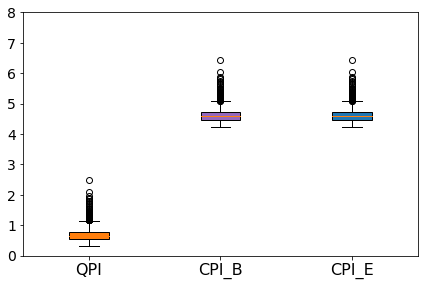

In [8]:
len_model = U_star_model - L_star_model



len_both = U_star_both - L_star_both

len_each = U_star_each - L_star_each

# 將數據存入列表中，準備繪製 boxplot
data = [len_model.flatten(), len_both.flatten(), len_each.flatten()]

colors = ['tab:orange', 'tab:purple', 'tab:blue']  # 颜色列表

# 創建一個圖，並繪製 boxplot
plt.figure(figsize=(6, 4))
box = plt.boxplot(data, patch_artist=True)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# 添加標籤
plt.xticks([1, 2, 3], ['QPI', 'CPI_B', 'CPI_E'], fontsize = 16)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.title('')
plt.tight_layout()
plt.ylim(0,8)

# 保存图形
filename = 'AvgLen_4.4.1.png'
path = os.path.join(folder+foldername, filename)
plt.savefig(path, dpi=300, bbox_inches='tight')
# show 
plt.show()

## Coverage rate

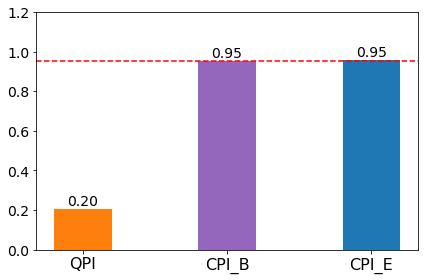

In [9]:
# 創建四個值對應 'Model', 'SCP', 'Cal_both', 'Cal_each'
values = [CR_test_model.item(), CR_test_both.item(), CR_test_each.item()]  # 這裡假設一些示範數據值
labels = ['QPI', 'CPI_B', 'CPI_E']

# 繪製長條圖，使用四個不同的顏色
colors = ['tab:orange', 'tab:purple', 'tab:blue']  # 颜色列表

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=colors, width=0.4)  # 調整 bar 的寬度

# 添加紅色和黑色的水平線
plt.axhline(y=0.95, color='red', linestyle='--', label='y=0.95')
# plt.axhline(y=1, color='black', linestyle='--', label='y=1')

# 添加数值在柱状图上方，并放置在红线附近
for i, value in enumerate(values):
    plt.text(i, values[i] + 0.02, f'{value:.2f}', ha='center', fontsize=14, color='black')


# 設定 y 軸範圍
plt.ylim(0, 1.2)

# 添加標籤和標題
plt.ylabel('')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 16)
plt.title('')
plt.tight_layout()

# 保存图形
filename = 'CR_4.4.1.png'
path = os.path.join(folder+foldername, filename)
plt.savefig(path, dpi=300, bbox_inches='tight')

# show
plt.show()